In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matlab.engine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import math
solvers.options['show_progress'] = False

eng = matlab.engine.start_matlab()
quarters = [('-01-01', '-03-31'), ('-04-01', '-06-30'), ('-07-01', '-09-30'), ('-10-01', '-12-31')]
years = [
    ('2016-01-01','2016-12-31'), 
    ('2017-01-01','2017-12-31'),
    ('2018-01-01','2018-12-31'), 
    ('2019-01-01','2019-12-31'), 
    ('2020-01-01','2020-12-31')
]
mu_si = np.array([0.22,0.54, 1.44, 2.42, 1.54])/100
mu_cl = np.add(mu_si, [.03]*5)
mu_si = mu_si/252
mu_cl = mu_cl/252

mu_safe = {}
mu_credit = {}

for year_index, year in enumerate(years):
    mu_safe[year[0][:4]] = mu_si[year_index]
    mu_credit[year[0][:4]] = mu_cl[year_index]

mu_si = mu_safe
mu_cl = mu_credit 

# assets = ['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX', 'AMZN', 'WMT', 'CVS']
# df = yf.download(assets, '2015-12-31', '2021-01-05')['Adj Close'].reindex(columns=assets)
# returns = (df - df.shift(1))/df.shift(1)

In [12]:
# Tested and returns same as matlab
def compute_y(var):
    ones = eng.transpose(matlab.double([1]*len(var)))
    return eng.mldivide(matlab.double(var.values.tolist()), matlab.double(ones))._data.tolist()

# Tested and returns same as matlab
def compute_z(mean, variance):
    return eng.mldivide(matlab.double(variance.values.tolist()), eng.transpose(matlab.double(mean.values.tolist())))._data.tolist()

# np.dot values return the same as matlab for test data
def compute_abc(mean, variance):
    y = compute_y(variance)
    z = compute_z(mean, variance)
    ones = [1]*len(mean)
    # a = sum(eng.times(ones, matlab.double(y))._data)
    # b = sum(eng.times(ones, matlab.double(z))._data)
    # c = sum(eng.times(ones, matlab.double(mean.values.tolist()))._data)
    return np.sum(np.array(ones).conj()*y, axis=0), np.sum(np.array(ones).conj()*z, axis=0), np.sum(np.array(mean.values.tolist()).conj()*z, axis=0)
    # return a,b,c

# returns same values as matlab
def compute_mv_vars(mean, variance):
    a,b,c = compute_abc(mean, variance)
    sigma_mv = 1/(a**0.5)
    mu_mv = b/a
    nu_as = ((a*c - b**2)/a)**0.5
    return sigma_mv, mu_mv, nu_as

    
def is_solvent(portfolio, returns):
    return not any(y <= 0 for y in [1 + np.dot(portfolio, returns.iloc[day]) for day in range(len(returns))])

def is_long(portfolio):
    return not any(y < 0 for y in portfolio.tolist())

In [4]:
class Portfolio:
    def __init__(self, assets, start_date='2005-12-28', end_date='2021-01-05'):
        self.data = yf.download(assets, start_date, end_date)['Adj Close']
        self.data = self.data.reindex(columns=assets)
        self.returns = (self.data - self.data.shift(1))/self.data.shift(1)
        self.start_date = start_date
        self.end_date = end_date
        
    # Returns mean and variance of portfolio for period
    def get_mean_and_variance(self, period_start = None, period_end = None):
        
        # Can add checks to make sure dates are valid with data that is contained
        if period_start is not None and period_end is not None:
            return self.returns[period_start:period_end].mean(), self.returns[period_start:period_end].cov()
        
        return self.returns.mean(), self.returns.cov()

    # Returns minimum volatility portfolio allocation and parameters
    def get_minimum_volatility_portfolio_parameters(self, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        sigma_mv, mu_mv, nu_as = compute_mv_vars(m, V)
        y = compute_y(V)

        f_mv = (sigma_mv**2)*np.array(y)

        return pd.Series(data=f_mv, index=self.data.columns), sigma_mv, mu_mv, nu_as

    # Returns safe tangent portfolio allocation if it exists and relevant parameters
    def get_safe_tangent_portfolio_parameters(self, mu_si, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv < mu_si:
            return None
        
        sigma_st = sigma_mv*(1 + ((nu_as*sigma_mv)/(mu_mv-mu_si))**2)**0.5
        mu_st = mu_mv + (nu_as**2)*(sigma_mv**2)/(mu_mv-mu_si)
        nu_st = nu_as*(1 + ((mu_mv-mu_si)/(nu_as*sigma_mv))**2)**0.5

        y = compute_y(V)
        z = compute_z(m, V)

        f_st = (sigma_mv**2/(mu_mv-mu_si))*(z - mu_si*np.array(y)).reshape((len(m)))

        return pd.Series(data=f_st, index=self.data.columns), sigma_st, mu_st, nu_st

    def get_credit_tangent_portfolio_parameters(self, mu_cl, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv < mu_cl:
            return None

        sigma_ct = sigma_mv*(1 + ((nu_as*sigma_mv)/(mu_mv-mu_cl))**2)**0.5
        mu_ct = mu_mv + (nu_as**2)*(sigma_mv**2)/(mu_mv-mu_cl)
        nu_ct = nu_as*(1 + ((mu_mv-mu_cl)/(nu_as*sigma_mv))**2)**0.5

        y = compute_y(V)
        z = compute_z(m, V)

        f_ct = (sigma_mv**2/(mu_mv-mu_cl))*(z - mu_cl*np.array(y)).reshape((len(m)))

        return pd.Series(data=f_ct, index=self.data.columns), sigma_ct, mu_ct, nu_ct
        
    def get_long_tangent_portfolio(self, mu_si, period_start=None, period_end=None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        mu_start = min(m)
        mu_end = max(m)
        step_size = (mu_end - mu_start)/3000

        long_mus = np.arange(mu_start, mu_end + step_size, step_size)

        # Long Frontier
        Q = matrix(V.values, tc='d')
        z = matrix(np.zeros((len(V))).tolist(), tc='d')
        I = matrix((-1*np.identity(len(V))), tc='d')
        A = matrix(np.array([np.ones((len(V))).tolist(), m.values.tolist()]), tc='d')

        nu_ca = (None, None, None, -100)
        
        # Will need to adjust for time periods longer than a year
        year = period_start[:4]

        for cur_mu in long_mus:
            deq = matrix(np.array([1, cur_mu]), tc='d')
            sol = solvers.qp(Q, z, I, z, A, deq)
            current_long_allocation = np.reshape(np.array(sol['x']), (len(m)))            

            sigma_lf = (np.matmul(np.matmul(current_long_allocation, V.values), np.reshape(current_long_allocation, (len(current_long_allocation),1)))[0])**0.5
            
            # Finding capital allocation line with greatest slope
            curNu_ca = (cur_mu - mu_si)/sigma_lf

            if curNu_ca > nu_ca[-1]:
                nu_ca = (current_long_allocation, sigma_lf, cur_mu, curNu_ca)

        return nu_ca

In [5]:
groupA = Portfolio(['VFIAX', 'VBTLX', 'VGSLX'])
groupAB = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX'])
groupABC = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX', 'AMZN', 'WMT', 'CVS'])

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  9 of 9 completed


In [19]:
lgd_groupA = mpatches.Patch(color='blue', label='Group A')
lgd_groupAB = mpatches.Patch(color='red', label='Group AB (And Assets Not Included in A)')
lgd_groupABC = mpatches.Patch(color='green', label='Group ABC (And Assets Not Included in AB)')
assets = Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='Assets', markersize=12)
rf = Line2D([0], [0], marker='D', color='w', markerfacecolor='k', label='Risk Free Rates', markersize=12)
ctg = Line2D([0], [0], marker='*', color='w', markerfacecolor='k', label='Credit Tangent Portfolio', markersize=12)
stg = Line2D([0], [0], marker='^', color='w', markerfacecolor='k', label='Safe Tangent Portfolio', markersize=12)
ltg = Line2D([0], [0], marker='X', color='w', markerfacecolor='k', label='Long Tangent Portfolio', markersize=12)
equi = Line2D([0], [0], marker='P', color='w', markerfacecolor='k', label='Equidistributed Portfolio', markersize=12)
mv_portfolio = Line2D([0], [0], marker='s', color='w', markerfacecolor='k', label='Minimum Variance Portfolio', markersize=12)
mv_frontier = Line2D([0], [0], linewidth=1., color='k', label='Minimum Variance Frontier', markersize=12)
efficient_frontier = Line2D([0], [0], linestyle='--', linewidth=1., color='k', label='Efficient Frontier', markersize=12)
efficient_frontier.set_linestyle('--')
long_frontier = Line2D([0], [0], linestyle=':', linewidth=1., color='k', label='Long Frontier', markersize=12)
long_frontier.set_linestyle(':')
lmtd_frontier_1 = Line2D([0], [0], linestyle='-.', linewidth=1., color='m', label='Limited Leverage Frontier (l = 1)', markersize=12)
lmtd_frontier_1.set_linestyle('-.')
lmtd_frontier_5 = Line2D([0], [0], linestyle='-.', linewidth=1., color='c', label='Limited Leverage Frontier (l = 5)', markersize=12)
lmtd_frontier_5.set_linestyle('-.')

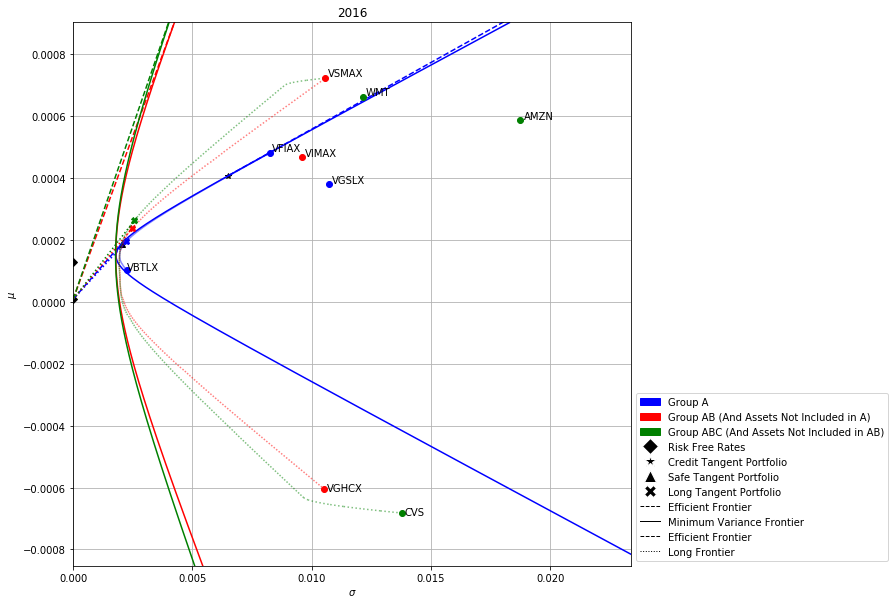

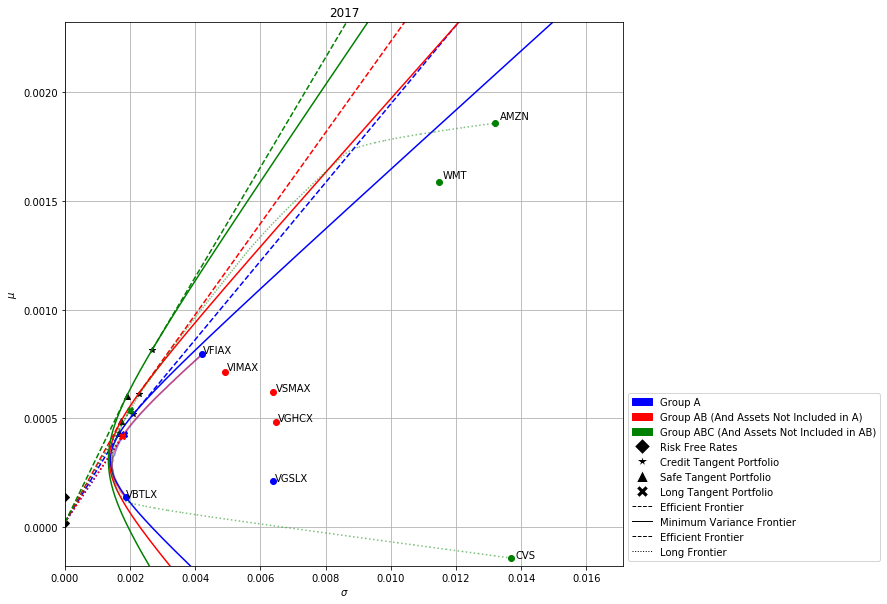

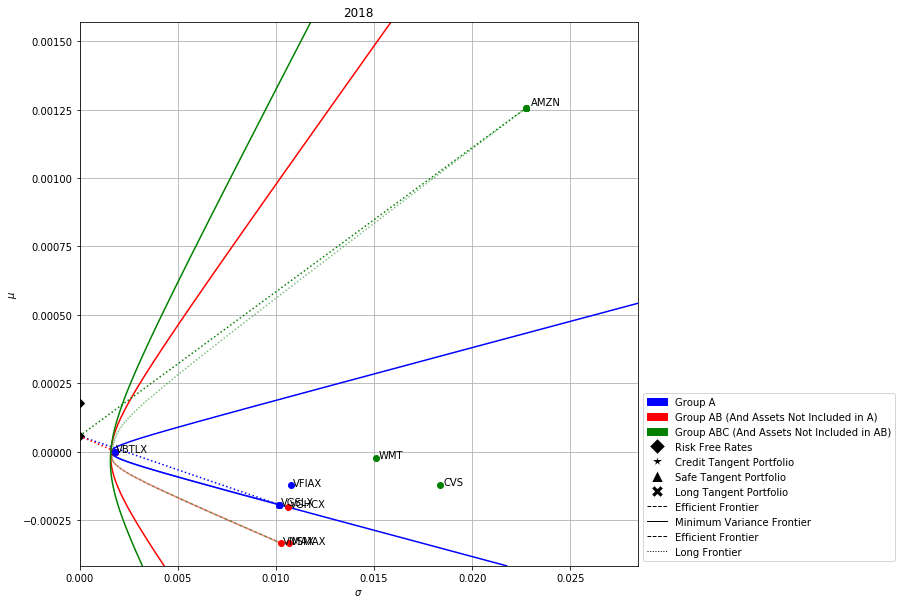

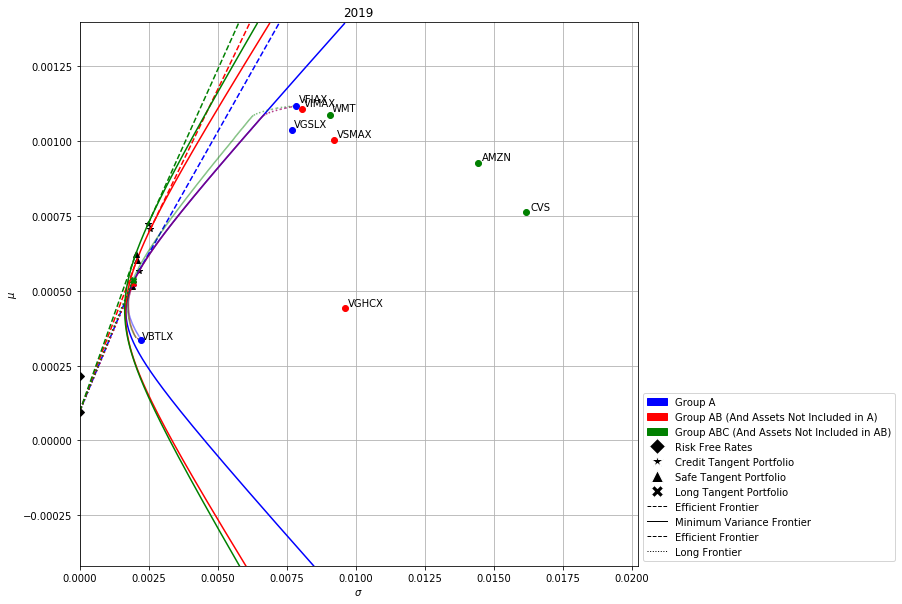

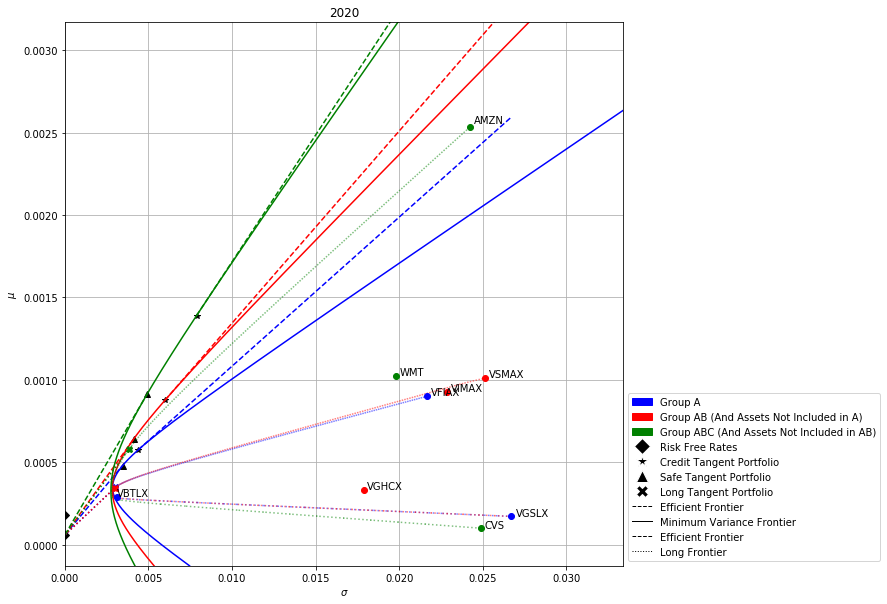

In [20]:
# Creating efficient frontier graphs
for year_index, (start, end) in enumerate(years):

    period_start = start
    period_end = end

    year = start[:4]
   
    plt.figure(num=year_index, figsize=(10,10))
    colors = ['b', 'r', 'g']

    m_all, V_all = groupABC.get_mean_and_variance(period_start, period_end)

    mu_end = abs(m_all.max())*1.25
    mu_start = -abs(m_all.min())*1.25
    max_sigma = V_all.values.max()**0.5
    y_lim = m_all.min()*1.5

    plt.plot(0, mu_si[year], 'kD')
    plt.plot(0, mu_cl[year], 'kD')

    for group_number, portfolio in enumerate([groupA, groupAB, groupABC]):

        m,V = portfolio.get_mean_and_variance(period_start, period_end)

        # Efficient frontier calculations and plotting
        _, sigma_mv, mu_mv, nu_as = portfolio.get_minimum_volatility_portfolio_parameters(period_start, period_end)

        st_vals = portfolio.get_safe_tangent_portfolio_parameters(mu_si[year], period_start, period_end)
        ct_vals = portfolio.get_credit_tangent_portfolio_parameters(mu_cl[year], period_start, period_end)

        if st_vals is not None:
            _, sigma_st, mu_st, nu_st = st_vals

            plt.plot(sigma_st, mu_st, 'k^')
            plt.plot([0, sigma_st], [mu_si[year], mu_si[year] + nu_st*sigma_st], colors[group_number] + '--')
        
        if ct_vals is not None:
            _, sigma_ct, mu_ct, nu_ct = ct_vals

            plt.plot(sigma_ct, mu_ct, 'k*')
            plt.plot([sigma_ct, max_sigma], [mu_ct, mu_cl[year] + nu_ct*max_sigma], colors[group_number] + '--')

        mus = np.arange(mu_start, mu_end, 0.000005)
        frontier = np.reshape([(sigma_mv**2 + ((mu - mu_mv)/nu_as)**2)**0.5 for mu in mus], (len(mus)))
        plt.plot(frontier, mus, colors[group_number])


        # Efficient long frontier 
        f_lt, sigma_lt, mu_lt, nu_lt = portfolio.get_long_tangent_portfolio(mu_si[start[:4]], period_start, period_end)

        plt.plot(sigma_lt, mu_lt, colors[group_number] + 'X')
        plt.plot([0, sigma_lt], [mu_si[start[:4]], mu_lt], colors[group_number] + ':')

        min_mu = min(m)
        max_mu = max(m)
        step_size = (max_mu-min_mu)/200

        long_mus = np.arange(min_mu, max_mu + step_size, step_size)

        previous_mu = long_mus[0]

        Q = matrix(V.values, tc='d')
        z = matrix(np.zeros((len(V))).tolist(), tc='d')
        I = matrix((-1*np.identity(len(V))), tc='d')
        A = matrix(np.array([np.ones((len(V))).tolist(), m.values.tolist()]), tc='d')
        deq = matrix(np.array([1, previous_mu]), tc='d')
        sol = solvers.qp(Q, z, I, z, A, deq)

        prev_long_allocation = np.reshape(np.array(sol['x']), (len(m))) 
        for cur_mu in long_mus[1:]:

            mu_range = np.arange(previous_mu, cur_mu+((cur_mu-previous_mu)/20), (cur_mu-previous_mu)/20)

            deq = matrix(np.array([1, cur_mu]), tc='d')
            sol = solvers.qp(Q, z, I, z, A, deq)
            current_long_allocation = np.reshape(np.array(sol['x']), (len(m)))            

            # Linear interpolation between allocations for 2 mus (Long frontier)
            f_lf = [(cur_mu - mu)/(cur_mu - previous_mu)*prev_long_allocation + (mu - previous_mu)/(cur_mu - previous_mu)*current_long_allocation for mu in mu_range]
            sigma_lf = [(np.matmul(np.matmul(f, V.values), np.reshape(f, (len(f),1)))[0])**0.5 for f in f_lf]
                       
            # Plot long frontier linear interpolation
            plt.plot(sigma_lf, mu_range, colors[group_number]+':', alpha=0.5)

            previous_mu = cur_mu
            prev_long_allocation = current_long_allocation

    

    for j in range(len(m_all)):
        plt.plot(V_all.iloc[j,j]**0.5, m_all[j], colors[int(j/3)] + 'o')
        plt.annotate(V_all.index[j], (1.01*V_all.iloc[j,j]**0.5, 1.01*m_all[j]))

    lgd = plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1, handles=[lgd_groupA, lgd_groupAB, lgd_groupABC, rf, ctg, stg, ltg, mv_frontier, efficient_frontier, long_frontier])
    plt.xlabel('$\sigma$')
    plt.ylabel('$\mu$')
    plt.ylim(mu_start, mu_end)
    plt.xlim(0, max_sigma*1.25)
    plt.title(period_start[:4])
    plt.grid()

    # plt.savefig('Graphs/longFrontiers/Year_' + str(year_index+1) + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()